         Date  Price
0  2025-03-24   4.03
1  2025-03-21   3.93
2  2025-03-20   4.23
3  2025-03-19   4.21
4  2025-03-18   4.17
Epoch 0, Iteration 0: Loss = 0.03640242666006088
Epoch 0, Iteration 1: Loss = 0.03541899472475052
Epoch 0, Iteration 2: Loss = 0.034811295568943024
Epoch 0, Iteration 3: Loss = 0.03563077747821808
Epoch 0, Iteration 4: Loss = 0.03263937681913376
Epoch 0, Iteration 5: Loss = 0.04009806364774704
Epoch 0, Iteration 6: Loss = 0.04220440611243248
Epoch 0, Iteration 7: Loss = 0.0377342663705349
Epoch 0, Iteration 8: Loss = 0.040088213980197906
Epoch 0, Iteration 9: Loss = 0.035501085221767426
Epoch 0, Iteration 10: Loss = 0.038723818957805634
Epoch 0, Iteration 11: Loss = 0.03546980023384094
Epoch 0, Iteration 12: Loss = 0.03356584906578064
Epoch 0, Iteration 13: Loss = 0.038139428943395615
Epoch 0, Iteration 14: Loss = 0.033655039966106415
Epoch 0, Iteration 15: Loss = 0.039813049137592316
Epoch 0, Iteration 16: Loss = 0.03742483630776405
Epoch 0, Iteration 17: Loss 

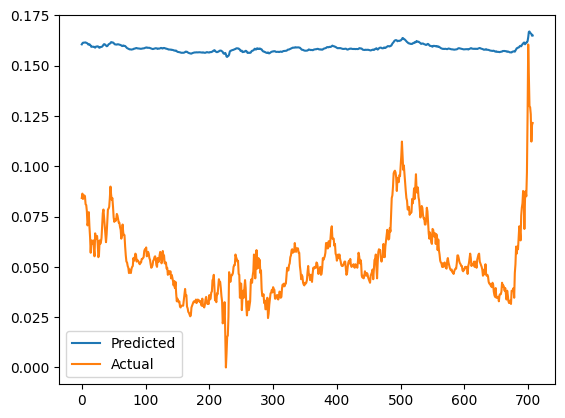

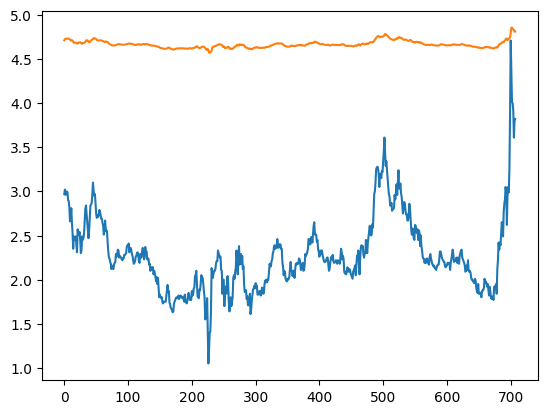

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn

# Load the dataset (Ensure to adjust the file path if necessary)
df = pd.read_csv("naturalgases.csv")  # Replace with the correct path
print(df.head())  # Inspect the first few rows

# Drop rows with missing values (if any)
df = df.dropna()

# Ensure 'Price' column exists and normalize the prices
y = df['Price'].values
x = np.arange(1, len(y) + 1, 1)

# Normalize the price range between 0 and 1
minm = y.min()
maxm = y.max()
y = (y - minm) / (maxm - minm)

# Sequence length (using the last 10 days to predict the 11th day)
Sequence_Length = 10
X = []
Y = []

for i in range(0, len(y) - Sequence_Length):
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
    X.append(list1)
    Y.append(y[i + Sequence_Length])  # The target value is the price on the 11th day

# Convert lists to arrays
X = np.array(X)
Y = np.array(Y)

# Split the data into train and test sets (90% for training, 10% for testing)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=False)

# Create a custom Dataset for PyTorch
class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

# Create data loaders for training
dataset = NGTimeSeries(x_train, y_train)
train_loader = DataLoader(dataset, shuffle=True, batch_size=256)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        output, _status = self.lstm(x)
        output = output[:, -1, :]  # Get the last output
        output = self.fc1(torch.relu(output))
        return output

# Initialize the model, loss function, and optimizer
model = LSTMModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
epochs = 100
for epoch in range(epochs):
    for i, data in enumerate(train_loader):
        # Reshape the input to (batch_size, sequence_length, input_size)
        y_pred = model(data[0].view(-1, Sequence_Length, 1)).reshape(-1)
        loss = criterion(y_pred, data[1])
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Iteration {i}: Loss = {loss.item()}")

# Testing the model
test_set = NGTimeSeries(x_test, y_test)
test_pred = model(test_set[:][0].view(-1, 10, 1)).view(-1)

# Plot the predicted and actual values
plt.plot(test_pred.detach().numpy(), label='Predicted')
plt.plot(test_set[:][1].view(-1), label='Actual')
plt.legend()
plt.show()

# Undo normalization
y_test_original = y_test * (maxm - minm) + minm
test_pred_original = test_pred.detach().numpy() * (maxm - minm) + minm

# Plot the original values
plt.plot(y_test_original)
plt.plot(range(len(y_test_original) - len(test_pred_original), len(y_test_original)), test_pred_original)
plt.show()
